In [ ]:
from tensorflow import keras 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [ ]:
#import pip

#package_names=['tqdm', 'matplotlib'] #packages to install
#pip.main(['install'] + package_names + ['--upgrade']) 
#conda install tqdm

In [ ]:
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
from PIL import Image
from matplotlib import pyplot as plt
import shutil

In [ ]:
pip install py7zr

     |████████████████████████████████| 65 kB 6.5 MB/s  eta 0:00:01
     |████████████████████████████████| 120 kB 31.5 MB/s eta 0:00:01
     |████████████████████████████████| 357 kB 28.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 30.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 27.3 MB/s eta 0:00:01
     |████████████████████████████████| 401 kB 28.4 MB/s eta 0:00:01     |███████████████████████▊        | 296 kB 28.4 MB/s eta 0:00:01
     |████████████████████████████████| 112 kB 27.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import py7zr
with py7zr.SevenZipFile('fbh.7z', mode='r') as z:
    z.extractall()

In [ ]:
#di = ''#r'C:\Users\Tanya\Desktop\GAN_Celeba\fbh'

In [ ]:
len(os.listdir('fbh'))

23316

100%|██████████| 23316/23316 [01:15<00:00, 310.49it/s]


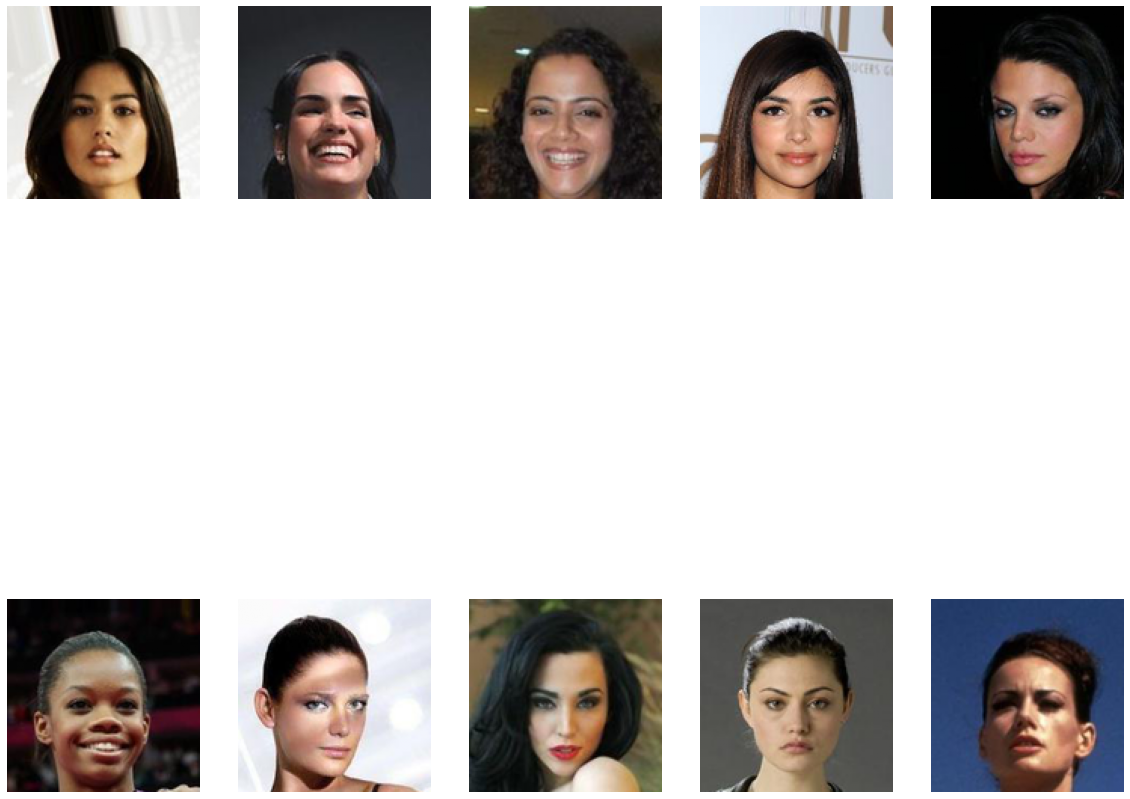

In [ ]:
PIC_DIR = 'fbh'#'/content/gdrive/MyDrive/Celeba/fbh_/'#'/content/gdrive/MyDrive/Celeba/cel/img_align_celeba/'
#r'C:\Users\Tanya\Desktop\img_align_celeba'#r'C:\Users\Tanya\Desktop\GAN_Celeba\img_align_celeba'

IMAGES_COUNT = 23316
ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2
WIDTH = 128
HEIGHT = 128
crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)
images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Image.open(PIC_DIR +'/'+ pic_file).crop(crop_rect)
    pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
    images.append(np.uint8(pic)) #Normalize the images
images = np.array(images) / 255
images.shape 
#print first 5 images
plt.figure(1, figsize=(20, 20))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [ ]:
LATENT_DIM = 32
CHANNELS = 3
def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))
    
    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)
    
    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)
    
    generator = Model(gen_input, x)
    return generator

In [ ]:
def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))
    
    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    
    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)
    
    optimizer = RMSprop(
        learning_rate=.0001,
        clipvalue=1.0,
        decay=1e-8
    )
    
    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )
    
    return discriminator


In [ ]:
generator = create_generator()
discriminator = create_discriminator()
discriminator.trainable = False


W0822 08:43:11.441771 140640679196480 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)#Adversarial Model
optimizer = RMSprop(learning_rate=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

In [ ]:
#import tensorflow as tf

In [ ]:
#To shutdown warning irrelevant for GANs
def _check_trainable_weights_consistency(self):
    return
keras.Model._check_trainable_weights_consistency = _check_trainable_weights_consistency

In [ ]:
import time
iters = 20000
batch_size = 16

FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)
CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2
start = 0
d_losses = []
a_losses = []
images_saved = 0
for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)
    
    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])
    
    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)
    
    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)
    
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))
    
    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)
    
    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0
    
    if step % 50 == 49:
        gan.save_weights('gan3.h5')
        
        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))
        
        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)
        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
        im = Image.fromarray(np.uint8(control_image * 255))
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1

plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(d_losses)
plt.xlabel('Epochs')
plt.ylabel('Discriminant losses')
plt.subplot(122)
plt.plot(a_losses)
plt.xlabel('Epochs')
plt.ylabel('Adversary losses')
plt.show()

50/20000: d_loss: 0.7607,  a_loss: 1.9937.  (2.1 sec)
100/20000: d_loss: 0.5698,  a_loss: 0.8634.  (2.1 sec)
150/20000: d_loss: 0.6471,  a_loss: 1.1244.  (2.1 sec)
200/20000: d_loss: 0.5355,  a_loss: 1.3212.  (2.1 sec)
250/20000: d_loss: 0.5644,  a_loss: 1.5517.  (2.1 sec)
300/20000: d_loss: 0.6143,  a_loss: 1.7212.  (2.1 sec)
350/20000: d_loss: 0.7287,  a_loss: 1.0074.  (2.1 sec)
400/20000: d_loss: 0.7155,  a_loss: 1.0952.  (2.1 sec)
450/20000: d_loss: 0.6164,  a_loss: 0.8426.  (2.1 sec)
500/20000: d_loss: 0.6451,  a_loss: 1.0571.  (2.1 sec)
550/20000: d_loss: 0.6035,  a_loss: 0.9332.  (2.1 sec)
600/20000: d_loss: 0.6672,  a_loss: 0.9405.  (2.1 sec)
650/20000: d_loss: 0.7208,  a_loss: 1.2219.  (2.1 sec)
700/20000: d_loss: 0.6944,  a_loss: 0.7379.  (2.1 sec)
750/20000: d_loss: 0.7212,  a_loss: 1.0050.  (2.1 sec)
800/20000: d_loss: 0.7125,  a_loss: 0.8355.  (2.1 sec)
850/20000: d_loss: 0.7105,  a_loss: 0.9094.  (2.1 sec)
900/20000: d_loss: 0.6678,  a_loss: 0.8179.  (2.1 sec)
950/20000: 

In [ ]:
RES_DIR = 'res5'

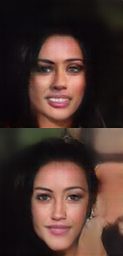

In [ ]:
#Showing the last generated image
im = Image.open(RES_DIR+'/generated_399.png')
 
# Size of the image in pixels (size of original image)
# (This is not mandatory)
width, height = im.size
 
# Setting the points for cropped image
left = 5
#top = height / 4
right = width/6

#bottom = 3 * height / 4
top = height / 3
bottom = 2*height / 3
 
# Cropped image of above dimension
# (It will not change original image)
im1 = im.crop((left, top, right,bottom))#, bottom))
 
# Shows the image in image viewer
im1.show()

In [ ]:
im.size

(768, 768)